In [1]:
# !git clone https://github.com/hannahpu/widsdatathon2022.git
# ! ls ./widsdatathon2022
# ! pip install nb-black

In [2]:
# ! ls ..

In [3]:
import sys

import pandas as pd
import catboost as cb
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

# Will need enable_iterative_imputer import otherwise IterativeImputer
# gives import error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder

sys.path.append("..")
import global_vars as gv
from utils import model_utils as mu
from utils import data_utils as du
from utils import data_process_utils as dpu
from utils import visualize as viz

# from utils.data_utils im"port *
# from utils.data_process_utils import *
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
wids_path = "../"

<IPython.core.display.Javascript object>

In [5]:
test_df = pd.read_csv("../data/test.csv")
print(f"Test dimension: {test_df.shape}")
train_df = pd.read_csv("../data/train.csv")
print(f"Train dimension: {train_df.shape}")
sample_solution_df = pd.read_csv("../data/sample_solution.csv")
print(f"Sample solution dimension: {sample_solution_df.shape}")
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()

Test dimension: (9705, 63)
Train dimension: (75757, 64)
Sample solution dimension: (9705, 2)


<IPython.core.display.Javascript object>

In [6]:
# Add parsed facility type, after parsing it has 20 types
train_w_parsed_facility_type_df = dpu.parse_facility_type(
    input_df=train_df.copy(), facility_type_colname="facility_type"
)
test_w_parsed_facility_type_df = dpu.parse_facility_type(
    input_df=test_df.copy(), facility_type_colname="facility_type"
)

<IPython.core.display.Javascript object>

In [7]:
# Backfill missing 'direction_max_wind_speed' with categorized values based on
# ["state_factor", "year"] aggregation
groupby_list = ["state_factor", "year_factor"]
col = "direction_max_wind_speed"

train_backfill_direction_max_wind_speed_df = dpu.backfill_wind_direction(
    input_df=train_w_parsed_facility_type_df,
    mapping_df=train_w_parsed_facility_type_df,
    groupby_list=groupby_list,
    wind_direction_colname=col,
    agg_approach_func=np.nanmean,
)
# Because there is only one year in test data therefore backfill based on
# ["state_factor", "year_factor"] won't work, therefore we only used "state_factor"
# instead
test_backfill_direction_max_wind_speed_df = dpu.backfill_wind_direction(
    input_df=test_w_parsed_facility_type_df,
    mapping_df=train_w_parsed_facility_type_df,
    groupby_list=["state_factor"],
    wind_direction_colname=col,
    agg_approach_func=np.nanmean,
)
# print(train_backfill_direction_max_wind_speed_df.filter(like="direction_max").info())
# print(test_backfill_direction_max_wind_speed_df.filter(like="direction_max").info())

# Get categorized on 'backfilled_direction_max_wind_speed'
backfilled_max_wind_speed_col = "backfilled_direction_max_wind_speed"
train_w_categorized_max_wind_speed_df = (
    train_backfill_direction_max_wind_speed_df.assign(
        categorized_direction_max_wind_speed=lambda df: df[
            backfilled_max_wind_speed_col
        ].apply(
            lambda a_direction_value: dpu.categorize_wind_direction(
                wind_direction_degree=a_direction_value, n_bins_categorized=8
            )
        )
    )
)

test_w_categorized_max_wind_speed_df = test_backfill_direction_max_wind_speed_df.assign(
    categorized_direction_max_wind_speed=lambda df: df[
        backfilled_max_wind_speed_col
    ].apply(
        lambda a_direction_value: dpu.categorize_wind_direction(
            wind_direction_degree=a_direction_value, n_bins_categorized=8
        )
    )
)
# print(train_w_categorized_max_wind_speed_df.filter(like="categorized_direction"))
# print(test_w_categorized_max_wind_speed_df.filter(like="categorized_direction"))

<IPython.core.display.Javascript object>

**Use iterative imputer to impute energy star ratings**

With PCA components = 4 which explains 81% variance and one-hot-encoding. The categorical features used in the imputer are "state_factor", "building_class", and "facility_type_parsed". The numerical features are all below temp columns

In [8]:
train_impute_energy_star_df = train_w_categorized_max_wind_speed_df.copy()
test_impute_energy_star_df = test_w_categorized_max_wind_speed_df.copy()

# Run a PCA for missing value imputation in energy star rating
cols_to_reduce_numerical = gv.below_temp_col_list 
cols_to_reduce_categorical = ["state_factor", 
                              "building_class", 
                              "facility_type_parsed"]

# Need a one-hot-encoding
train_impute_energy_star_dfs_list = []
test_impute_energy_star_dfs_list = []
for a_categorical_col in cols_to_reduce_categorical:
    onehot_encoder = OneHotEncoder().fit(
      train_impute_energy_star_df[[a_categorical_col]])
    train_impute_energy_star_transformed_array = onehot_encoder.transform(
      train_impute_energy_star_df[[a_categorical_col]]).toarray()
    test_impute_energy_star_transformed_array = onehot_encoder.transform(
      test_impute_energy_star_df[[a_categorical_col]]).toarray()
    
    train_impute_energy_star_transformed_df = pd.DataFrame(
      train_impute_energy_star_transformed_array, 
      columns=[f"{a_categorical_col}_{i}" for i in 
               range(train_impute_energy_star_transformed_array.shape[1])])
    test_impute_energy_star_transformed_df = pd.DataFrame(
      test_impute_energy_star_transformed_array, 
      columns=[f"{a_categorical_col}_{i}" for i in 
               range(test_impute_energy_star_transformed_array.shape[1])])
    
    train_impute_energy_star_dfs_list.append(train_impute_energy_star_transformed_df)
    test_impute_energy_star_dfs_list.append(test_impute_energy_star_transformed_df)

# Merge processed categorical data into one based on index
train_impute_energy_star_processed_categorical_df = pd.concat(
    train_impute_energy_star_dfs_list, axis=1
)
test_impute_energy_star_processed_categorical_df = pd.concat(
    test_impute_energy_star_dfs_list, axis=1
)

scaled_train_impute_energy_star_df, scaled_test_impute_energy_star_df = mu.scale_data(
    train_impute_energy_star_df[cols_to_reduce_numerical], 
    test_impute_energy_star_df[cols_to_reduce_numerical]
)

# Merge processed categorical and numerical together
train_impute_energy_star_merged_df = train_impute_energy_star_processed_categorical_df.merge(
   scaled_train_impute_energy_star_df, left_index=True, right_index=True,
   how="left" 
)

test_impute_energy_star_merged_df = test_impute_energy_star_processed_categorical_df.merge(
   scaled_test_impute_energy_star_df, left_index=True, right_index=True,
   how="left" 
)


<IPython.core.display.Javascript object>

In [9]:
train_impute_energy_star_merged_df.shape

(75757, 37)

<IPython.core.display.Javascript object>

In [10]:
# Find the optimal PCA for energy star imputation
# 4 can already explain 81% varience
for n_component in range(1, 8):
    pca = du.pca_fit(train_impute_energy_star_merged_df, n_components=n_component)
    scaled_train_impute_energy_star_w_pca = pca.transform(
        train_impute_energy_star_merged_df
    )
    scaled_test_impute_energy_star_w_pca = pca.transform(
        test_impute_energy_star_merged_df
    )
    print(sum(pca.explained_variance_ratio_[:4]))

Fitting PCA with 1 components
0.35658576032912437
Fitting PCA with 2 components
0.5933198019960959
Fitting PCA with 3 components
0.7206991605976221
Fitting PCA with 4 components
0.8136952019723978
Fitting PCA with 5 components
0.813695201972416
Fitting PCA with 6 components
0.8136952019724146
Fitting PCA with 7 components
0.8136952019724111


<IPython.core.display.Javascript object>

In [11]:
pca = du.pca_fit(train_impute_energy_star_merged_df, n_components=4)
scaled_train_impute_energy_star_w_pca_optimal = pca.transform(
    train_impute_energy_star_merged_df
)
scaled_test_impute_energy_star_w_pca_optimal = pca.transform(
    test_impute_energy_star_merged_df
)
print(sum(pca.explained_variance_ratio_[:4]))

Fitting PCA with 4 components
0.8136952019724096


<IPython.core.display.Javascript object>

In [12]:
scaled_train_impute_energy_star_w_pca_optimal_df = pd.DataFrame(
    scaled_train_impute_energy_star_w_pca_optimal,
    columns=[
        f"pca_{i}"
        for i in range(scaled_train_impute_energy_star_w_pca_optimal.shape[1])
    ],
)

scaled_test_impute_energy_star_w_pca_optimal_df = pd.DataFrame(
    scaled_test_impute_energy_star_w_pca_optimal,
    columns=[
        f"pca_{i}" for i in range(scaled_test_impute_energy_star_w_pca_optimal.shape[1])
    ],
)

# Add back original energy star rating
scaled_train_w_original_energy_star_df = (
    scaled_train_impute_energy_star_w_pca_optimal_df.merge(
        train_impute_energy_star_df["energy_star_rating"],
        how="left",
        left_index=True,
        right_index=True,
    )
)
scaled_test_w_original_energy_star_df = (
    scaled_test_impute_energy_star_w_pca_optimal_df.merge(
        test_impute_energy_star_df["energy_star_rating"],
        how="left",
        left_index=True,
        right_index=True,
    )
)

<IPython.core.display.Javascript object>

In [13]:
# Get backfilled energy star rating using scikit-learn iterative imputer based on 
# other features
random_state = 42
max_iter = 10
imp = IterativeImputer(max_iter=max_iter, random_state=random_state)
# Fit the imputer on training
imp.fit(scaled_train_w_original_energy_star_df)
# Transform on train and test
scaled_train_w_original_energy_star_transformed_df = pd.DataFrame(
    imp.transform(scaled_train_w_original_energy_star_df),
    columns=scaled_train_w_original_energy_star_df.columns.tolist()
    )
scaled_test_w_original_energy_star_transformed_df = pd.DataFrame(
    imp.transform(scaled_test_w_original_energy_star_df),
    columns=scaled_test_w_original_energy_star_df.columns.tolist()
    )


<IPython.core.display.Javascript object>

### Add imputed energy star with other processed columns

In [14]:
train_processed_df = train_w_categorized_max_wind_speed_df.merge(
    scaled_train_w_original_energy_star_transformed_df[["energy_star_rating"]].rename(
        columns={"energy_star_rating": "iter_impute_renergy_star_rating"}
    ),
    how="left",
    left_index=True,
    right_index=True,
)
test_processed_df = test_w_categorized_max_wind_speed_df.merge(
    scaled_test_w_original_energy_star_transformed_df[["energy_star_rating"]].rename(
        columns={"energy_star_rating": "iter_impute_renergy_star_rating"}
    ),
    how="left",
    left_index=True,
    right_index=True,
)
train_processed_df.head()

,year_factor,state_factor,building_class,facility_type,floor_area,year_built,energy_star_rating,elevation,january_min_temp,january_avg_temp,...,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,facility_type_parsed,direction_max_wind_speed_backfilled,backfilled_direction_max_wind_speed,categorized_direction_max_wind_speed,iter_impute_renergy_star_rating
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,1.0,1.0,NaN,248.682615,0,Grocery,1.0,1.0,N,11.0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,NaN,1.0,12.0,26.500150,1,Warehouse,1.0,1.0,N,45.0
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,NaN,1.0,12.0,24.693619,2,Retail,1.0,1.0,N,97.0
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,NaN,1.0,12.0,48.406926,3,Education,1.0,1.0,N,46.0
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,1.0,1.0,NaN,3.899395,4,Warehouse,1.0,1.0,N,100.0


<IPython.core.display.Javascript object>

In [15]:
seed = 0
depth = 12

model_dict = {
    "catboost": cb.CatBoostRegressor(
        loss_function="RMSE",
        depth=depth,
        random_seed=seed,
        verbose=False,
        nan_mode="Min",
    ),
    "xgboost": xgb.XGBRegressor(
        eval_metric="rmse",
        seed=seed,
        max_depth=3,
        n_estimators=100,
        booster="gbtree",
        n_jobs=-1,
        random_state=0,
        learning_rate=0.1,
    ),
}

model_type_dict = {"catboost": "catboost", "xgboost": "sklearn"}

feature_dict = {
    "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost": {
        "cols_to_reduce_dict": {"temp": viz.temp_col_list},
        "reduce_number_dict": {"temp": 0},
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "if_scale": False,
        "model": "catboost",
        "replace_original_feature_col_dict": {
            "energy_star_rating": "iter_impute_renergy_star_rating",
            "facility_type": "facility_type_parsed",
            # "direction_max_wind_speed": "categorized_direction_max_wind_speed"
        },
        "drop_data": {},
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "smote",
        },
    }
}

model_configs_to_run = [
    "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost"
]

<IPython.core.display.Javascript object>

In [16]:
train_filled_df = train_processed_df.copy()
test_filled_df = test_processed_df.copy()

<IPython.core.display.Javascript object>

Fitting PCA with 9 components
log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost ['days_above_90f', 'days_below_10f', 'max_wind_speed', 'days_above_110f', 'snowdepth_inches', 'direction_max_wind_speed', 'days_below_30f', 'state_factor', 'precipitation_inches', 'elevation', 'cooling_degree_days', 'snowfall_inches', 'days_below_0f', 'days_above_100f', 'heating_degree_days', 'building_class', 'days_below_20f', 'year_built', 'days_above_80f', 'days_with_fog', 'direction_peak_wind_speed', 'temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4', 'temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'temp_pca9', 'iter_impute_renergy_star_rating', 'facility_type_parsed', 'log10_floor_area'] True
Running catboost
Modeling 1...
Modeling 2...
Modeling 3...
Modeling 4...
Modeling 5...
Modeling 6...
Average RMSE:
left_out_year     3.500000
train_rmse       17.244938
test_rmse        55.384514
dtype: float64


,left_out_year,train_rmse,test_rmse
0,1,17.806883,67.397333
1,2,16.424218,46.498981
2,3,17.931650,60.976550
3,4,17.816126,55.144646
4,5,17.109658,49.087078
5,6,16.381093,53.202495


Whole data train RMSE: 26.5533038084134


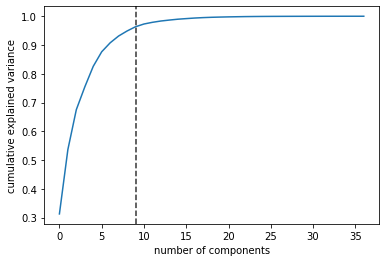

<IPython.core.display.Javascript object>

In [17]:
for config_name in model_configs_to_run:
    # get model config
    cols_to_reduce_dict = feature_dict[config_name]["cols_to_reduce_dict"]
    reduce_number_dict = feature_dict[config_name]["reduce_number_dict"]
    log10_transform_cols = feature_dict[config_name]["log10_transform_cols"]
    if_one_hot = feature_dict[config_name]["if_one_hot"]
    if_scale = feature_dict[config_name]["if_scale"]
    replace_original_feature_col_dict = feature_dict[config_name][
        "replace_original_feature_col_dict"
    ]
    resample_param_dict = feature_dict[config_name]["resample_param_dict"]
    drop_data_dict = feature_dict[config_name]["drop_data"]
    model_name = feature_dict[config_name]["model"]
    model = model_dict[model_name]
    # check if need to drop data
    if len(drop_data_dict) > 0:
        for one_col, drop_level_list in drop_data_dict.items():
            train_filled_df = train_filled_df.query(
                f"{one_col} not in {drop_level_list}"
            )
    # process data
    train_filter_df, test_filter_df, pca_cols = du.process_data_v1(
        train_filled_df.drop_duplicates(),
        test_filled_df.drop_duplicates(),
        reduce_col_dict=cols_to_reduce_dict,
        cols_to_log_transform=log10_transform_cols,
        reduce_number_dict=reduce_number_dict,
    )
    # Set feature columns after data transformations
    all_cols_to_reduce = []
    for _, one_set_col_to_reduce in cols_to_reduce_dict.items():
        all_cols_to_reduce = all_cols_to_reduce + one_set_col_to_reduce

    all_cols_to_drop = []
    all_cols_to_replace_from_drop = []
    for col_to_drop, col_to_replace in replace_original_feature_col_dict.items():
        all_cols_to_drop.append(col_to_drop)
        all_cols_to_replace_from_drop.append(col_to_replace)

    features_columns = (
        list(
            set(gv.all_feature_columns)
            - set(all_cols_to_reduce)
            - set(log10_transform_cols)
            - set(all_cols_to_drop)
        )
        + pca_cols
        + all_cols_to_replace_from_drop
        + [f"log10_{col}" for col in log10_transform_cols]
    )
    print(config_name, features_columns, if_one_hot)

    # run model
    ## Run LOY model
    model_rmse = mu.run_leave_year_out(
        model_df=train_filter_df,
        ml_model=model,
        features_columns=features_columns,
        if_scale_data=if_scale,
        if_one_hot=if_one_hot,
        model_type=model_type_dict[model_name],
        resample_param_dict=resample_param_dict,
    )
    print(f"Average RMSE:\n{model_rmse.mean()}")
    display(model_rmse)

    ## predict on test data
    if len(resample_param_dict) > 0:
        train_for_resample_df = train_filter_df
        resample_by_col = resample_param_dict["resample_by_col"]
        resample_type = resample_param_dict["resample_type"]
        if resample_param_dict["up_or_downsample"] == "upsample":
            train_filter_x_df = mu.upsampling_by_column(
                train_for_resample_df, resample_by_col, resample_type=resample_type
            )
        elif resample_param_dict["up_or_downsample"] == "downsample":
            train_filter_x_df = mu.downsampling_by_column(
                train_for_resample_df, resample_by_col, resample_type=resample_type
            )

    train_filter_x_df, train_filter_y_df = mu.split_model_feature_response(
        train_filter_df, features_columns
    )
    test_filter_x_df = mu.split_model_feature_response(
        test_filter_df, features_columns, if_with_response=False
    )
    processed_train_x_df, processed_test_x_df = mu.process_train_test_data(
        train_filter_x_df,
        test_filter_x_df,
        if_scale,
        if_one_hot,
        full_data_df=train_filter_x_df,
    )
    run_model_dict = {
        "xgboost": mu.run_sklearn_model,
        "catboost": mu.run_catboost_model,
    }
    train_predict, test_predict, fitted_model = run_model_dict[model_name](
        model, processed_train_x_df, train_filter_y_df, processed_test_x_df
    )
    training_rmse = mu.calculate_rmse(train_filter_y_df, train_predict)
    print(f"Whole data train RMSE: {training_rmse}")

### Save output result

In [23]:
# model_rmse.loc[model_rmse.shape[0], :] = [0, training_rmse, np.nan]
model_rmse["method"] = model_rmse["left_out_year"].apply(
    lambda x: "loyo" if x > 0 else "whole train"
)
display(model_rmse)
# model_rmse.to_csv(f"{wids_path}prediction_result/meng/{config_name}.csv", index=False)

print(f"Average RMSE:\n{model_rmse.query('left_out_year != 0').mean()}")
display(model_rmse)

test_prediction_result = test_df[["id"]]
test_prediction_result["site_eui"] = test_predict
test_prediction_result.to_csv(
    f"{wids_path}prediction_result/meng/{config_name}.csv", index=False
)

# if model_name == "catboost":
#     viz.plot_catboost_feature_importance(model)
#     plt.savefig(
#         f"{wids_path}/validation_result/hannah/{config_name}_feature_importance.png"
#     )
#     plt.close()
# elif model_name == "xgboost":
#     fig, ax = plt.subplots(figsize=(15, 20))
#     xgb.plot_importance(fitted_model, ax=ax)
#     plt.savefig(
#         f"{wids_path}/validation_result/hannah/{config_name}_feature_importance.png"
#     )
#     plt.close()


# rmse_df = du.get_rmse_by_group(
#     train_filter_x_df.rename(
#         columns={"backfilled_energy_star_rating": "energy_star_rating", "backfilled_energy_star_rating_v1": "energy_star_rating", "facility_type_parsed": "facility_type"}
#     ),
#     train_filter_y_df,
#     train_predict,
# )
# viz.plot_rmse_by_group(rmse_df)
# plt.savefig(
#     f"{wids_path}/validation_result/hannah/{config_name}_rmse_by_group.png"
# )
# plt.close()

,left_out_year,train_rmse,test_rmse,method
0,1.0,17.806883,67.397333,loyo
1,2.0,16.424218,46.498981,loyo
2,3.0,17.931650,60.976550,loyo
3,4.0,17.816126,55.144646,loyo
4,5.0,17.109658,49.087078,loyo
5,6.0,16.381093,53.202495,loyo
6,0.0,26.553304,NaN,whole train
7,NaN,NaN,NaN,whole train


Average RMSE:
left_out_year     3.500000
train_rmse       17.244938
test_rmse        55.384514
dtype: float64


,left_out_year,train_rmse,test_rmse,method
0,1.0,17.806883,67.397333,loyo
1,2.0,16.424218,46.498981,loyo
2,3.0,17.931650,60.976550,loyo
3,4.0,17.816126,55.144646,loyo
4,5.0,17.109658,49.087078,loyo
5,6.0,16.381093,53.202495,loyo
6,0.0,26.553304,NaN,whole train
7,NaN,NaN,NaN,whole train


/Users/mengzhao/opt/miniconda3/envs/ds_challenge/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


<IPython.core.display.Javascript object>